# Utils

In [1]:
from utils import *
import torch
import matplotlib.pyplot as plt
import numpy as np
from geodesic_toolbox import *
from scipy.interpolate import CubicSpline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Finsler Manifold

## Metric setup

In [3]:
def generate_circle(N_pts, r, noise):
    theta_0 = torch.linspace(0, np.pi, N_pts // 2)
    theta_1 = torch.linspace(-np.pi, 0, N_pts // 2)
    r0 = r + torch.randn(N_pts // 2) * noise
    r1 = r + torch.randn(N_pts // 2) * noise
    x_0 = r0 * torch.cos(theta_0)
    y_0 = r0 * torch.sin(theta_0)
    x_1 = r1 * torch.cos(theta_1)
    y_1 = r1 * torch.sin(theta_1)
    X_0 = torch.stack([x_0, y_0], dim=1)
    X_1 = torch.stack([x_1, y_1], dim=1)
    X_all = torch.cat([X_0, X_1], dim=0)

    c_0 = torch.ones(N_pts // 2)
    c_1 = -torch.ones(N_pts // 2)
    c_all = torch.cat([c_0, c_1], dim=0)

    t_0 = theta_0
    t_1 = theta_0.clone().flip(0)
    t_all = torch.cat([t_0, t_1], dim=0)
    # t_all = (t_all - t_all.min()) / (t_all.max() - t_all.min())
    return X_all, t_all, c_all


def get_class_labels(X):
    angles = torch.atan2(X[:, 1], X[:, 0])
    labels = 2 * (angles < 0).long() - 1
    return labels

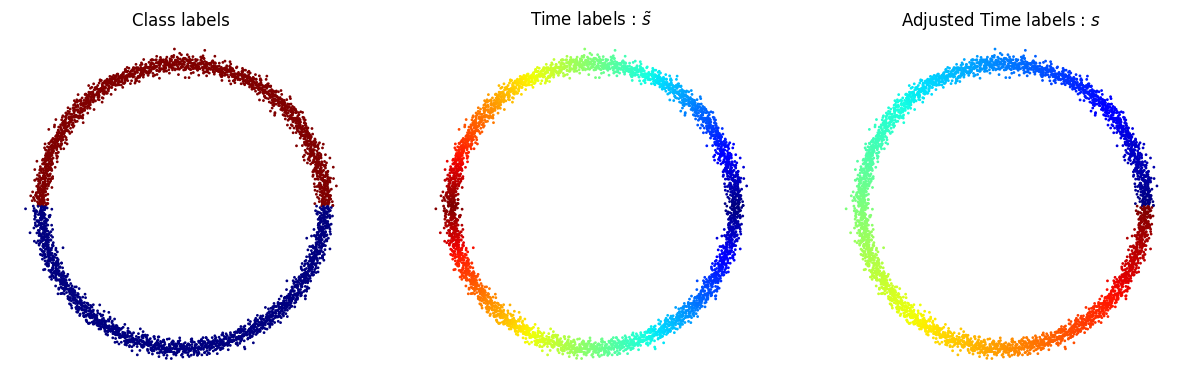

In [4]:
# Generate the data

N_pts_0 = 4000

# X_all, t_all = generate_two_sines(N_pts_0 // 2, noise=0.03)
X_all, t_all_tilde, c_all = generate_circle(N_pts_0, r=1.0, noise=0.03)
# X_all, t_all = generate_one_sines(N_pts_0)
# Random noise
# X_all = torch.randn(N_pts_0, 2)
# t_all = torch.rand(N_pts_0)

X_all = X_all.to(device)
t_all_tilde = t_all_tilde.to(device)
c_all = c_all.to(device)


t_all = t_all_tilde.clone()
M = t_all_tilde.max()  # M>max(t_all_tilde)
t_all[c_all == 1] = t_all_tilde[c_all == 1]
t_all[c_all == -1] = 2 * M - t_all_tilde[c_all == -1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(X_all[:, 0].cpu(), X_all[:, 1].cpu(), c=c_all.cpu(), cmap="jet", s=1)
ax1.set_title("Class labels")
# plt.colorbar(ax1.collections[0], ax=ax1, orientation="vertical", label="Class")
ax2.scatter(X_all[:, 0].cpu(), X_all[:, 1].cpu(), c=t_all_tilde.cpu(), cmap="jet", s=1)
ax2.set_title("Time labels : " + r"$\tilde{s}$")
# plt.colorbar(ax2.collections[0], ax=ax2, orientation="vertical", label="True Time")
ax3.scatter(X_all[:, 0].cpu(), X_all[:, 1].cpu(), c=t_all.cpu(), cmap="jet", s=1)
# ax3.scatter(
#     X_all[:, 0].cpu(), X_all[:, 1].cpu(), c=get_class_labels(X_all).cpu(), cmap="plasma", s=1
# )
ax3.set_title("Adjusted Time labels : " + r"$s$")
# plt.colorbar(ax3.collections[0], ax=ax3, orientation="vertical", label="Adjusted Time")
for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")
    ax.axis("off")
plt.show()

In [5]:
base_cometric = CentroidsCometric(
    centroids=X_all.to(device),
    cometric_centroids=IdentityCoMetric()(X_all).to(device),
    K=1024,
    temperature_scale=1.0,
)
theta_pred = HyperPlanPredictor(latent_dim=2, base_cometric=base_cometric).to(device)
rho_pred = AccuracyPredictor(latent_dim=2).to(device)
print(f"Initial temperature: {base_cometric.temperature.item():.4f}")
base_cometric.temperature = torch.tensor(0.03).to(device)

Initial temperature: 0.0723


In [6]:
class Omega(torch.nn.Module):
    def __init__(self, direction: torch.nn.Module, amplitude: torch.nn.Module):
        super().__init__()
        self.direction = direction
        self.amplitude = amplitude

    def forward(self, X):
        rho = self.amplitude(X).clip(0.0, 1.0)
        omega = self.direction(X)
        return rho * omega


omega = Omega(
    direction=theta_pred,
    amplitude=rho_pred,
).to(device)

Computing magnification factor: 100%|██████████| 79/79 [00:00<00:00, 756.49batch/s]


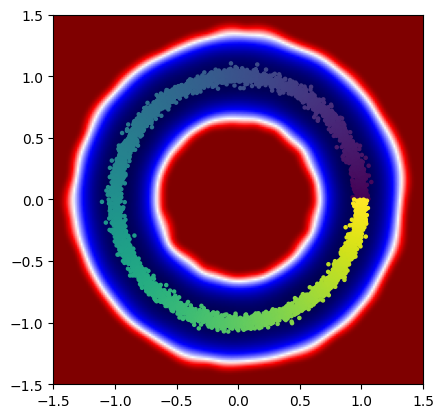

In [7]:
extent = (-1.2, 1.2, -0.7, 0.7)
extent = (-1.5, 1.5, -1.5, 1.5)  # Adjusted for circle data
mf = get_mf_image(base_cometric, X_all, bounds=extent)

plt.imshow(mf.log(), cmap="seismic", extent=extent, origin="lower")
plt.scatter(X_all[:, 0].cpu(), X_all[:, 1].cpu(), s=5, c=t_all.cpu(), cmap="viridis")
plt.show()

In [8]:
# Learn the omega hyperplane predictor

p_j = X_all[::100]
t_j = t_all[::100]

N_epochs = 200
lr = 0.02
margin = 0.001
K = 16
print(f"Using {K} nearest neighbors")

optim_theta = torch.optim.Adam(theta_pred.parameters(), lr=lr)
optim_rho = torch.optim.Adam(rho_pred.parameters(), lr=5 * lr)
loss_theta = MarginLoss(k=K, margin=margin)

losses_knn = []
accuracy_knn = []
true_acc_knn = []
for epoch in tqdm(range(N_epochs)):
    omega_i = theta_pred(X_all)

    # Direction optimization
    loss_knn = loss_theta(omega_i, X_all, t_all)
    optim_theta.zero_grad()
    loss_knn.backward()
    optim_theta.step()

    # Amplitude optimization
    true_acc = loss_theta.acc.detach().clone().unsqueeze(1)
    # Only relevant if acc >0.5
    true_val = 2 * (true_acc - 0.5).relu()
    pred_acc = rho_pred(X_all)
    loss_acc = torch.nn.functional.mse_loss(pred_acc, true_val)
    if epoch > 20:
        optim_rho.zero_grad()
        loss_acc.backward()
        optim_rho.step()

    losses_knn.append(loss_knn.item())
    accuracy_knn.append(loss_acc.item())
    true_acc_knn.append(true_val.mean().item())

Using 16 nearest neighbors


100%|██████████| 200/200 [00:01<00:00, 147.52it/s]


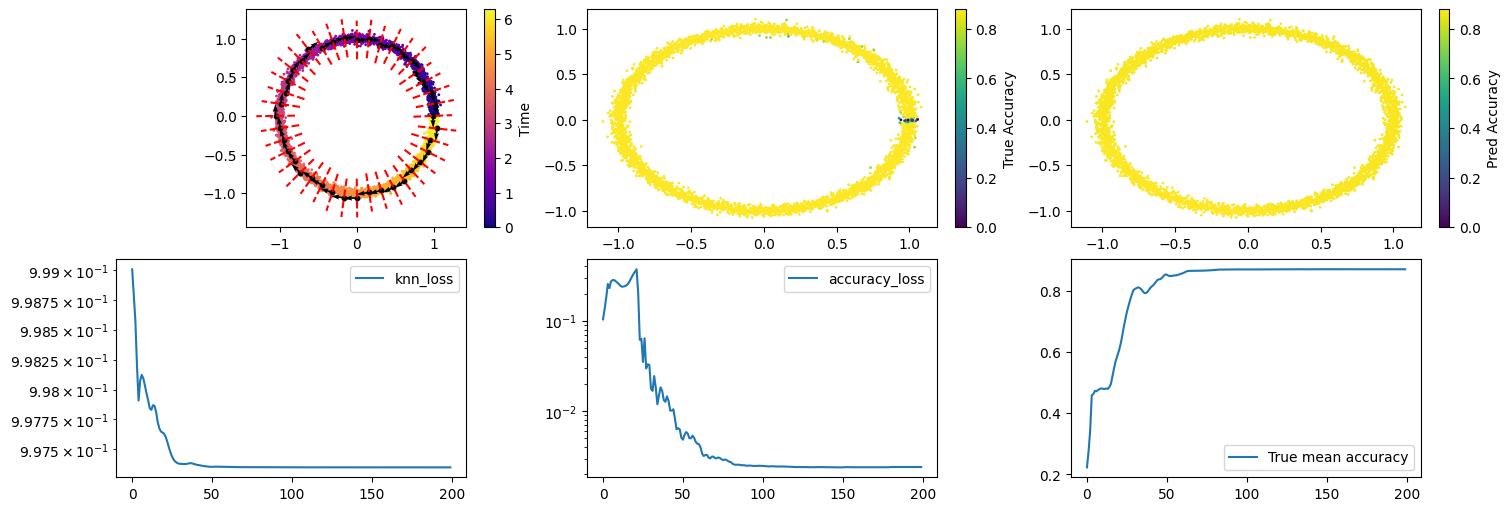

In [9]:
omega_j = omega(p_j)

fig, axes = plt.subplot_mosaic(
    [["A", "E", "F"], ["B", "C", "D"]], figsize=(15, 5), layout="constrained"
)
time = axes["A"].scatter(
    X_all[:, 0].cpu(), X_all[:, 1].cpu(), c=t_all.cpu(), cmap="plasma", s=1
)
axes["A"].scatter(p_j[:, 0].cpu(), p_j[:, 1].cpu(), s=10, c="black")
axes["A"].set_aspect("equal")
plot_hyperplane(p_j.cpu(), omega_j.detach().cpu(), axes["A"], line_length=0.5, arrow=True)
plt.colorbar(time, ax=axes["A"], label="Time")

vmax = max(true_val.max().item(), pred_acc.max().item())
vmin = min(true_val.min().item(), pred_acc.min().item())
acc = axes["E"].scatter(
    X_all[:, 0].cpu(),
    X_all[:, 1].cpu(),
    # c=true_acc.squeeze().cpu().detach(),
    c=true_val.squeeze().cpu().detach(),
    cmap="viridis",
    s=1,
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar(acc, ax=axes["E"], label="True Accuracy")

acc = axes["F"].scatter(
    X_all[:, 0].cpu(),
    X_all[:, 1].cpu(),
    c=pred_acc.squeeze().cpu().detach(),
    cmap="viridis",
    s=1,
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar(acc, ax=axes["F"], label="Pred Accuracy")

axes["B"].plot(losses_knn, label="knn_loss")
axes["C"].plot(accuracy_knn, label="accuracy_loss")
axes["D"].plot(true_acc_knn, label="True mean accuracy")
axes["D"].legend()
for val in ["B", "C"]:
    axes[val].legend()
    axes[val].set_yscale("log")

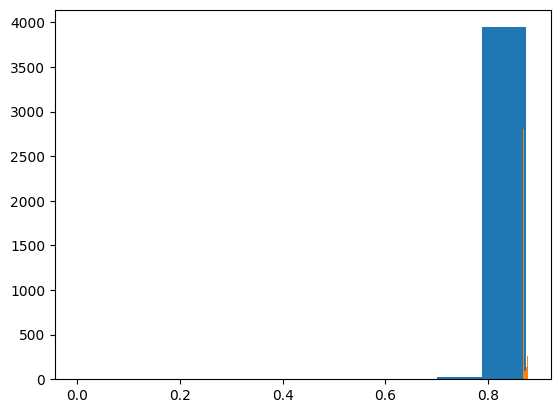

In [10]:
plt.hist(true_val.cpu())
plt.hist(pred_acc.cpu().detach())
plt.show()

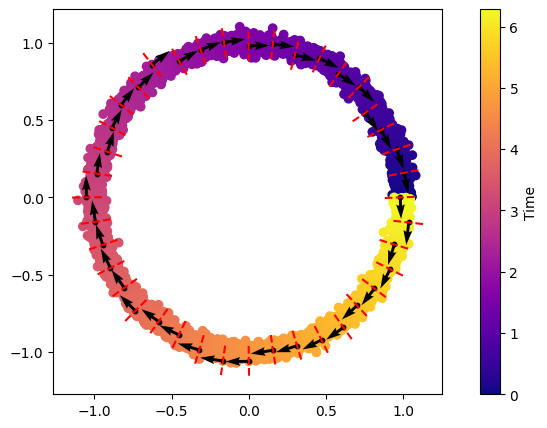

In [11]:
omega_j = omega(p_j)
fig, ax = plt.subplots(figsize=(10, 5))
time = ax.scatter(X_all[:, 0].cpu(), X_all[:, 1].cpu(), c=t_all.cpu(), cmap="plasma")
ax.scatter(p_j[:, 0].cpu(), p_j[:, 1].cpu(), s=10, c="black")
ax.set_aspect("equal")
plot_hyperplane(p_j.cpu(), omega_j.detach().cpu(), ax, line_length=0.2, arrow=True)
plt.colorbar(time, ax=ax, label="Time")

In [14]:
randers = RandersMetrics(
    base_cometric=base_cometric,
    # base_cometric=PointCarreCoMetric(),
    omega=omega,
    # beta=0.2,
).to(device)

In [15]:
z = torch.randn(1, 2).to(device)
v = torch.randn(1, 2).to(device)
g_true = randers.fundamental_tensor(z, v)
g_inv_true = g_true.inverse()

In [52]:
F = randers.forward(z, v)
alpha = randers.base_cometric.metric(z, v).sqrt()

a = randers.base_cometric.metric_tensor(z)
if randers.base_cometric.is_diag:
    a_inv = torch.diag_embed(1.0 / a, dim1=-2, dim2=-1)
else:
    # a = 1 / a
    a_inv = a.inverse()
print(f"{a_inv.shape=}, {a.shape = }")

fst_term = alpha / F * a_inv

b = randers.omega(z)
beta = randers.beta * torch.einsum("bi,bi->b", b, v)
b_tilde_top = torch.einsum("bij,bj->bi", a_inv, b)
b_tilde_norm = torch.einsum("bi,bi->b", b_tilde_top, b)
l_tilde = v / alpha


ll = torch.einsum("bi,bj->bij", l_tilde, l_tilde)
snd_term = alpha**2 / F**3 * (beta + alpha * b_tilde_norm) * ll

li_bj = torch.einsum("bi,bj->bij", l_tilde, b_tilde_top)
lj_bi = torch.einsum("bj,bi->bij", l_tilde, b_tilde_top)

trd_term = alpha**2 / F**2 * (li_bj + lj_bi)

g_inv_pred = fst_term + snd_term - trd_term

g_inv_pred - g_inv_true

a_inv.shape=torch.Size([1, 2, 2]), a.shape = torch.Size([1, 2, 2])


tensor([[[-10.1197,  -3.3771],
         [ -3.3771,  -1.1107]]], device='cuda:0', grad_fn=<SubBackward0>)

## Geodesics equation

In [13]:
N_pts = 25

# x_0 = torch.tensor([[-0.75, -0.2]], device=device).repeat(N_pts, 1)
x_0 = torch.tensor([[0.1, 0.5]], device=device).repeat(N_pts, 1)


# omega_x0 = randers.omega(x_0)
# sigma = randers.fundamental_tensor(x_0, -omega_x0).inverse()
# L = torch.linalg.cholesky(sigma)

torch.Size([25, 2])


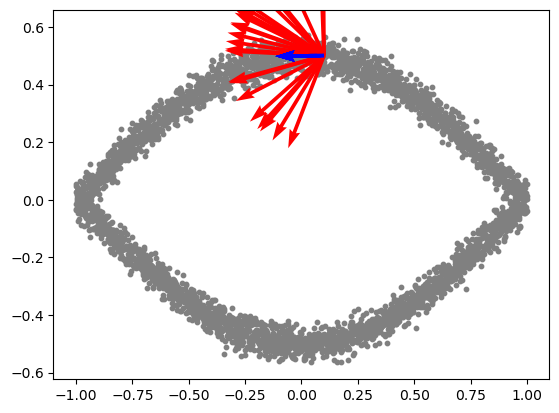

In [13]:
# v_0 = random_VMF(-omega_x0, kappa=2.0)
def get_kappa(latent_dim, alpha: float = 3, beta: float = 1):
    return alpha * latent_dim**beta


omega_x0 = randers.omega(x_0)
v_0 = sample_cone_VMF(x_0, randers, kappa=get_kappa(2, alpha=1))
print(v_0.shape)
# plt.scatter(x_0[:, 0].cpu(), x_0[:, 1].cpu(), c="red", s=50)
plt.scatter(X_all[:, 0].cpu(), X_all[:, 1].cpu(), c="gray", s=10)
for i in range(N_pts):
    plt.quiver(
        x_0[i, 0].cpu(),
        x_0[i, 1].cpu(),
        v_0[i, 0].cpu().detach(),
        v_0[i, 1].cpu().detach(),
        color="red",
        angles="xy",
        scale=5,
    )
    plt.quiver(
        x_0[i, 0].cpu(),
        x_0[i, 1].cpu(),
        -omega_x0[i, 0].cpu().detach(),
        -omega_x0[i, 1].cpu().detach(),
        color="blue",
        angles="xy",
        scale=1,
    )
# plt.gca().set_aspect("equal")

In [14]:
expmap = ExpMapFinsler(finsler=randers, T_max=1, T=100, method="euler")

traj = expmap(x_0, v_0).detach()

In [15]:
density_all = randers.base_cometric.inv_logdet(X_all)
mean_d = density_all.mean().item()
std_d = density_all.std().item()
print(f"Mean density: {mean_d:.3f} +- {std_d:.3f}")
threshold = mean_d - 5 * std_d

Mean density: 8.877 +- 0.155


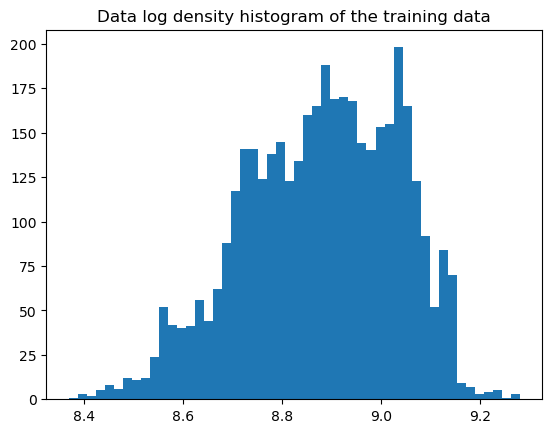

In [16]:
plt.hist(density_all.cpu(), bins=50)
plt.title("Data log density histogram of the training data")
plt.show()

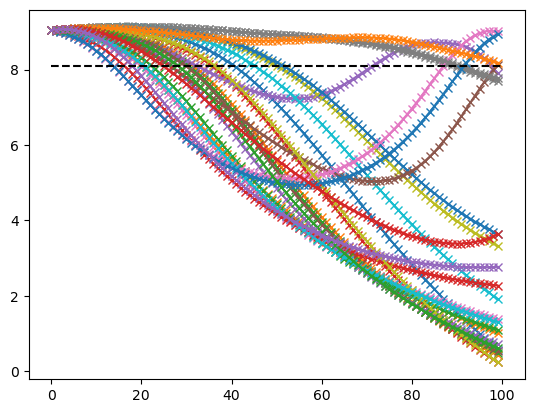

In [17]:
log_p_val = torch.stack(
    [randers.base_cometric.inv_logdet(traj[i]) for i in range(traj.shape[0])], dim=0
)
for i in range(N_pts):
    plt.plot(log_p_val[i].cpu(), label=f"Pt {i}", marker="x")
plt.hlines(
    threshold,
    0.0,
    log_p_val.shape[1],
    colors="black",
    linestyles="dashed",
    label="Threshold",
)
# plt.legend()
plt.show()

In [18]:
def filter_traj(traj: torch.Tensor, threshold: float, cometric: CoMetric):
    """
    Filter a trajectory based on a density threshold.
    Retrieve only the first points above the threshold.
    Resample the trajectory using cubic splines to keep the dimension of the trajectory.

    Parameters
    ----------
    traj : torch.Tensor (T,d)
        The trajectory to filter.
    threshold : float
        The density threshold. Points with density below this value will be removed.
    cometric : CoMetric
        The cometric used to compute the density.

    Returns
    -------
    torch.Tensor (T,d)
        The filtered trajectory.
    """
    d_traj = cometric.inv_logdet(traj)
    mask = d_traj < threshold
    idxs = torch.where(mask)[0]
    if len(idxs) == 0:
        return traj
    first_idx = idxs[0].item()
    valid_traj = traj[: first_idx + 1]

    cs = CubicSpline(
        torch.linspace(0, 1, valid_traj.shape[0]).cpu(),
        valid_traj.cpu(),
        axis=0,
    )
    new_traj = torch.tensor(cs(torch.linspace(0, 1, traj.shape[0])), device=traj.device)
    return new_traj


traj_filtered = [filter_traj(traj[i], threshold, randers.base_cometric) for i in range(N_pts)]

In [19]:
def plot_exp(X_all, traj, x_0, v_0, traj_filtered=None):
    plt.scatter(X_all[:, 0].cpu(), X_all[:, 1].cpu(), c="gray", s=10)
    for i in range(N_pts):
        traj_i = traj[i]
        plt.plot(traj_i[:, 0].cpu(), traj_i[:, 1].cpu(), label=f"traj {i}")
        plt.quiver(
            x_0[i, 0].cpu(),
            x_0[i, 1].cpu(),
            v_0[i, 0].cpu().detach(),
            v_0[i, 1].cpu().detach(),
            color="red",
            angles="xy",
        )

    if traj_filtered is not None:
        for i in range(N_pts):
            traj_i = traj_filtered[i]
            plt.plot(
                traj_i[:, 0].cpu(),
                traj_i[:, 1].cpu(),
                label=f"filtered traj {i}",
                linewidth=5,
            )

    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    # plt.legend()
    plt.show()

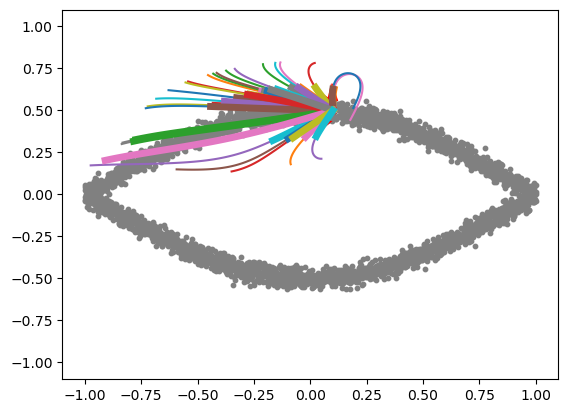

In [20]:
plot_exp(X_all, traj, x_0, v_0, traj_filtered=traj_filtered)

Method: euler
Time 0.000, Event value -0.200
Time 0.000, Event value -0.200
Time 0.010, Event value -0.190
Time 0.020, Event value -0.180
Time 0.030, Event value -0.170
Time 0.040, Event value -0.160
Time 0.050, Event value -0.150
Time 0.060, Event value -0.140
Time 0.070, Event value -0.130
Time 0.080, Event value -0.120
Time 0.090, Event value -0.110
Time 0.100, Event value -0.100
Time 0.110, Event value -0.090
Time 0.120, Event value -0.080
Time 0.130, Event value -0.070
Time 0.140, Event value -0.060
Time 0.150, Event value -0.050
Time 0.160, Event value -0.040
Time 0.170, Event value -0.030
Time 0.180, Event value -0.020
Time 0.190, Event value -0.010
Time 0.200, Event value 0.000
Time 0.195, Event value -0.005
Time 0.198, Event value -0.002
Time 0.199, Event value -0.001
Time 0.199, Event value -0.001
Time 0.200, Event value -0.000
Time 0.200, Event value -0.000
Time 0.200, Event value -0.000
Time 0.200, Event value -0.000
Time 0.200, Event value -0.000
Time 0.200, Event value -0

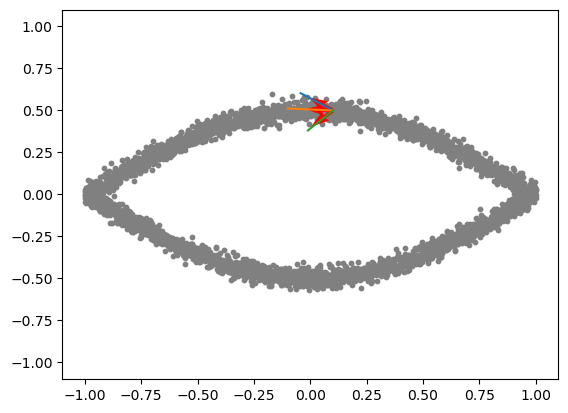

Method: rk4
Time 0.000, Event value -0.200
Time 0.000, Event value -0.200
Time 0.010, Event value -0.190
Time 0.020, Event value -0.180
Time 0.030, Event value -0.170
Time 0.040, Event value -0.160
Time 0.050, Event value -0.150
Time 0.060, Event value -0.140
Time 0.070, Event value -0.130
Time 0.080, Event value -0.120
Time 0.090, Event value -0.110
Time 0.100, Event value -0.100
Time 0.110, Event value -0.090
Time 0.120, Event value -0.080
Time 0.130, Event value -0.070
Time 0.140, Event value -0.060
Time 0.150, Event value -0.050
Time 0.160, Event value -0.040
Time 0.170, Event value -0.030
Time 0.180, Event value -0.020
Time 0.190, Event value -0.010
Time 0.200, Event value 0.000
Time 0.195, Event value -0.005
Time 0.198, Event value -0.002
Time 0.199, Event value -0.001
Time 0.199, Event value -0.001
Time 0.200, Event value -0.000
Time 0.200, Event value -0.000
Time 0.200, Event value -0.000
Time 0.200, Event value -0.000
Time 0.200, Event value -0.000
Time 0.200, Event value -0.0

KeyboardInterrupt: 

In [38]:
for method in ["euler", "rk4", "dopri5", "fehlberg2"]:
    print(f"Method: {method}")
    expmap = ExpMapFinsler(finsler=randers, T_max=0.2, T=100, method=method)

    traj = expmap(x_0, v_0).detach()
    plot_exp(X_all, traj, x_0, v_0)

## Solver showcase

In [16]:
## Graph solvers
riemann_solver = SolverGraph(cometric=base_cometric, data=X_all, n_neighbors=8, batch_size=512)
randers_solver = SolverGraphFinsler(
    finsler_metric=randers, data=X_all, n_neighbors=8, batch_size=512
)

Fitting KNN graph...


Initialize Graph: 100%|██████████| 8/8 [00:08<00:00,  1.05s/batch]


Computing predecessors...
Done.


Initialize Graph: 100%|██████████| 8/8 [00:23<00:00,  2.91s/batch]


Computing predecessors...
Done.


In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_traj_comparison(
    traj_0_randers, traj_0_riemann, X_all, q0, q1, t_all, t_all_tilde, c_all, suptitle=None
):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    def plt_axes(ax, c, label_cbar):
        ax.scatter(X_all[:, 0].cpu(), X_all[:, 1].cpu(), c=c.cpu(), cmap="jet", s=10)
        ax.plot(
            traj_0_riemann[0, :, 0].cpu(),
            traj_0_riemann[0, :, 1].cpu(),
            c="red",
            label="Geodesic Riemann",
        )
        ax.plot(
            traj_0_randers[0, :, 0].cpu(),
            traj_0_randers[0, :, 1].cpu(),
            c="blue",
            label="Geodesic Randers",
        )
        ax.scatter(q0[:, 0].cpu(), q0[:, 1].cpu(), c="black", s=50, label="Start")
        ax.scatter(q1[:, 0].cpu(), q1[:, 1].cpu(), c="green", s=50, label="End")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(ax.collections[0], cax=cax, orientation="vertical", label=label_cbar)

    plt_axes(axes[0], t_all_tilde.cpu(), "True Time")
    plt_axes(axes[1], t_all.cpu(), "Adjusted Time")
    plt_axes(axes[2], c_all.cpu(), "Class")
    for ax in axes:
        ax.set_aspect("equal")
        ax.set_axis_off()
        # ax.legend()
    axes[0].legend()

    if suptitle is not None:
        plt.suptitle(suptitle)
    # plt.show()
    return fig


def pts_circle(theta, r=1.0):
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    return torch.stack([x, y], dim=0).unsqueeze(0)

In [18]:
def count_inversion(a: Tensor) -> Tensor:
    """
    Count the number of inversions in batches of tensors using torch.
    An inversion is a pair of indices (i, j) such that i < j and a[i] > a[j].

    Parameters:
    a (Tensor): The input tensor of shape (B, N) where B is batch size and N is sequence length

    Returns:
    Tensor: The number of inversions for each sequence in the batch, shape (B,)
    """
    B, N = a.shape

    # Indices for all pairs (i, j) where i < j
    i_indices = torch.arange(N, device=a.device).unsqueeze(1).expand(N, N)
    j_indices = torch.arange(N, device=a.device).unsqueeze(0).expand(N, N)
    mask = i_indices < j_indices

    a_i = a.unsqueeze(2).expand(B, N, N)  # a_i[b, i, j] = a[b, i]
    a_j = a.unsqueeze(1).expand(B, N, N)  # a_j[b, i, j] = a[b, j]

    inversions = (a_i > a_j) & mask.unsqueeze(0)
    inversion_counts = inversions.sum(dim=(1, 2))

    return inversion_counts


def monotonicity_measure(a: Tensor):
    """
    Measure the monotonicity of a tensor.
    Returns 1 if the tensor is monotonic, 0 otherwise.
    Note that this is quite sensitive to noise.

    Parameters:
    -----------
    a : Tensor (B,N)

    Returns:
    -----------
    measure : Tensor (B,)
    """
    B, n = a.shape
    max_inv = (n * (n - 1)) / 2
    inv_count = count_inversion(a)
    return torch.abs(inv_count - max_inv / 2) / (max_inv / 2)

In [19]:
def get_angle(traj):
    """
    Computes polar angle of trajectory points.

    Parameters
    ----------
    traj : torch.Tensor
        A tensor of shape (B, T, 2) representing the trajectory points.

    Returns
    -------
    torch.Tensor
        A tensor of shape (B, T) representing the polar angles of the trajectory points.
    """
    x = traj[:, :, 0]
    y = traj[:, :, 1]
    signed_theta = torch.atan2(y, x)
    theta = signed_theta % (2 * np.pi)
    return theta

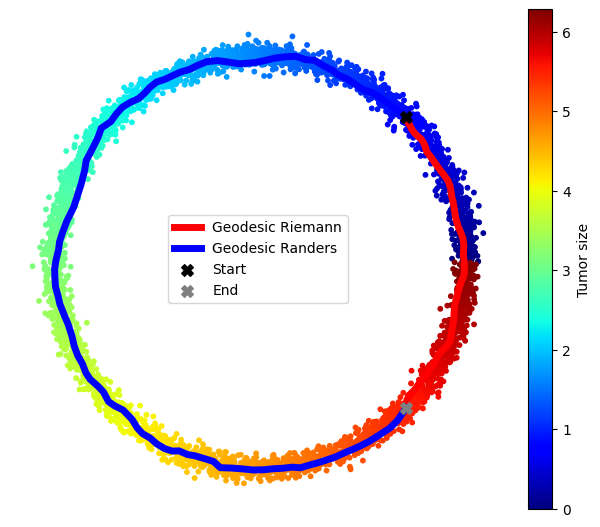

In [20]:
theta_0 = torch.tensor(np.pi / 4, device=device)
theta_1 = torch.tensor(-np.pi / 4, device=device)
q0 = pts_circle(theta_0).to(device)
q1 = pts_circle(theta_1).to(device)
traj_0_riemann = riemann_solver.get_trajectories(q0, q1, connect_euclidean=True)
traj_0_randers = randers_solver.get_trajectories(q0, q1, connect_euclidean=True)
angles_riemann = get_angle(traj_0_riemann)
angles_randers = get_angle(traj_0_randers)
mono_riemann = monotonicity_measure(angles_riemann).cpu().squeeze()
mono_randers = monotonicity_measure(angles_randers).cpu().squeeze()

# fig_theta = plot_traj_comparison(
#     traj_0_randers,
#     traj_0_riemann,
#     X_all,
#     q0,
#     q1,
#     t_all,
#     t_all_tilde,
#     c_all,
# )
fig, ax = plt.subplots(figsize=(7, 7))
img = ax.scatter(X_all[:, 0].cpu(), X_all[:, 1].cpu(), c=t_all.cpu(), cmap="jet", s=10)
ax.plot(
    traj_0_riemann[0, :, 0].cpu(),
    traj_0_riemann[0, :, 1].cpu(),
    c="red",
    label="Geodesic Riemann",
    linewidth=5,
)
ax.plot(
    traj_0_randers[0, :, 0].cpu(),
    traj_0_randers[0, :, 1].cpu(),
    c="blue",
    label="Geodesic Randers",
    linewidth=5,
)
ax.scatter(
    q0[:, 0].cpu(), q0[:, 1].cpu(), c="black", s=70, label="Start", marker="X", zorder=5
)
ax.scatter(q1[:, 0].cpu(), q1[:, 1].cpu(), c="grey", s=70, label="End", marker="X", zorder=5)
ax.set_aspect("equal")
ax.set_axis_off()
ax.legend()
fig.colorbar(img, ax=ax, label="Tumor size", fraction=0.046, pad=0.04)

In [21]:
from pathlib import Path

export_path = Path("./figures/randers_circle/")
export_path.mkdir(parents=True, exist_ok=True)

theta_0 = torch.tensor(np.pi / 4, device=device)
theta_1_list = theta_0 + torch.linspace(-np.pi, np.pi, 100).to(device)

mono_riemann_list = []
mono_randers_list = []
dtheta_list = []
for theta_1 in tqdm(theta_1_list):
    dtheta = theta_1 - theta_0
    dtheta_list.append(dtheta.cpu())
    q0 = pts_circle(theta_0)
    q1 = pts_circle(theta_1)
    traj_0_riemann = riemann_solver.get_trajectories(q0, q1, connect_euclidean=True)
    traj_0_randers = randers_solver.get_trajectories(q0, q1, connect_euclidean=True)
    angles_riemann = get_angle(traj_0_riemann)
    angles_randers = get_angle(traj_0_randers)
    mono_riemann_list.append(monotonicity_measure(angles_riemann).cpu().squeeze())
    mono_randers_list.append(monotonicity_measure(angles_randers).cpu().squeeze())
    # fig_theta = plot_traj_comparison(
    #     traj_0_randers,
    #     traj_0_riemann,
    #     X_all,
    #     q0,
    #     q1,
    #     t_all,
    #     t_all_tilde,
    #     c_all,
    #     suptitle=r"""$\delta \theta=$""" + f"{(dtheta).item()/(2*np.pi)*360:.1f}°",
    # )
    # fig_theta.savefig(
    #     export_path
    #     / f"randers_circle_delta_theta_{(dtheta).item()/(2*np.pi)*360:.1f}.png",
    #     dpi=500,
    # )
    # plt.close(fig_theta)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 17.06it/s]


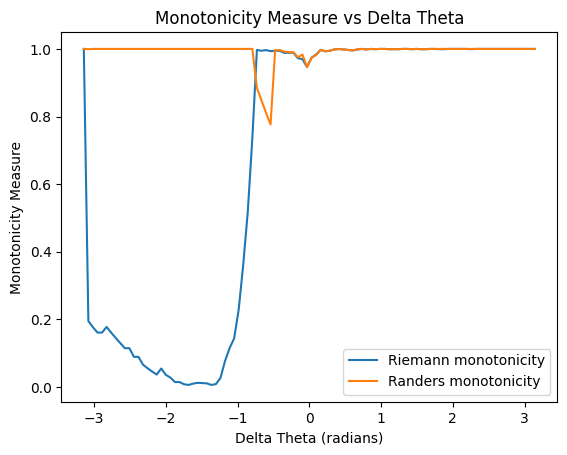

In [22]:
plt.plot(dtheta_list, mono_riemann_list, label="Riemann monotonicity")
plt.plot(dtheta_list, mono_randers_list, label="Randers monotonicity")
plt.xlabel("Delta Theta (radians)")
plt.ylabel("Monotonicity Measure")
plt.legend()
plt.title("Monotonicity Measure vs Delta Theta")
plt.show()

In [5]:
# Load the exported images
import imageio
from pathlib import Path

export_path = Path("./figures/randers_circle/")
images = []
for path in tqdm(list(export_path.glob("randers_circle_delta_theta_*.png"))):
    images.append(imageio.imread(path))
# imageio.mimsave(
#     export_path / "randers_circle_animation.gif",
#     images,
#     fps=10,
#     loop=0,
# )

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_30744/1761283460.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path))
100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


In [17]:
# Resize images
import numpy as np
from PIL import Image

s = 0.33  # scaling factor
print("Initial image size:", images[0].shape)
print("Scaling factor :", s)
images_resized = [
    np.array(Image.fromarray(img).resize((int(7500 * s), int(2500 * s)))) for img in images
]
print("Resized image size:", images_resized[0].shape)

Initial image size: (2500, 7500, 4)
Scaling factor : 0.33


In [18]:
imageio.mimsave(
    export_path / "randers_circle_animation.gif",
    images_resized,
    fps=10,
    loop=0,
)

In [112]:
# Define the solvers

## Graph solvers
riemann_solver = SolverGraph(cometric=base_cometric, data=X_all, n_neighbors=8, batch_size=512)
randers_solver = SolverGraphFinsler(
    finsler_metric=randers, data=X_all, n_neighbors=8, batch_size=512
)

## GEORCE solvers
riemann_georce = GEORCE(base_cometric, T=100, max_iter=300, tol=1e-5, pbar=True)
randers_georce = GEORCEFinsler(randers, T=100, max_iter=300, tol=1e-5, pbar=True)

## Dual solvers
dual_riemann_georce = SolverGraphGEORCE(
    cometric=base_cometric,
    data=X_all,
    n_neighbors=8,
    pbar_georce=True,
    batch_size=512,
    max_iter=100,
    tol=1e-5,
)
dual_randers_georce = SolverGraphGEORCEFinsler(
    finsler=randers,
    data=X_all,
    n_neighbors=8,
    pbar_georce=True,
    batch_size=512,
    max_iter=100,
    tol=1e-5,
)

Fitting KNN graph...


Initialize Graph:   0%|          | 0/8 [00:00<?, ?batch/s]

Initialize Graph: 100%|██████████| 8/8 [00:29<00:00,  3.73s/batch]


Computing predecessors...
Done.


Initialize Graph:  25%|██▌       | 2/8 [00:22<01:06, 11.02s/batch]


KeyboardInterrupt: 

In [ ]:
q0 = X_all[0:1]
q1 = X_all[-2:-1]
# idx = torch.randint(0, X_all.shape[0], (2,))
# q0 = X_all[idx[0:1]]
# q1 = X_all[idx[1:2]]
# q0 = torch.tensor([[-1.0, 0.5]], device="cuda")
# q1 = torch.tensor([[1.0, -0.5]], device="cuda")

<Axes: >

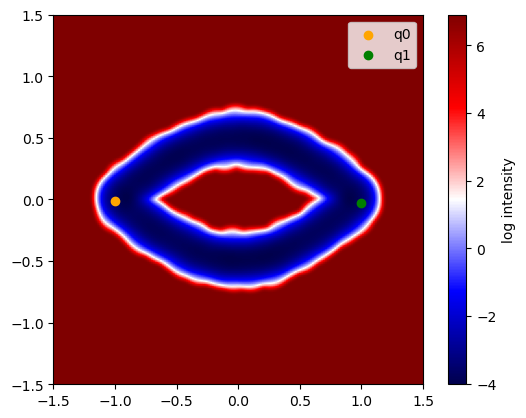

In [ ]:
plot_traj(q0=q0.cpu(), q1=q1.cpu(), img=mf, extent=extent)

In [ ]:
# Graph trajectories
traj_0_graph = randers_solver.get_trajectories(q0, q1, connect_euclidean=True)
traj_1_graph = randers_solver.get_trajectories(q1, q0, connect_euclidean=True)
traj_riemann_0 = riemann_solver.get_trajectories(q0, q1, connect_euclidean=True)

dst_0_graph = randers_solver.compute_distance(traj_0_graph)
dst_1_graph = randers_solver.compute_distance(traj_1_graph)
dst_riemann_0 = riemann_solver.compute_distance(traj_riemann_0)

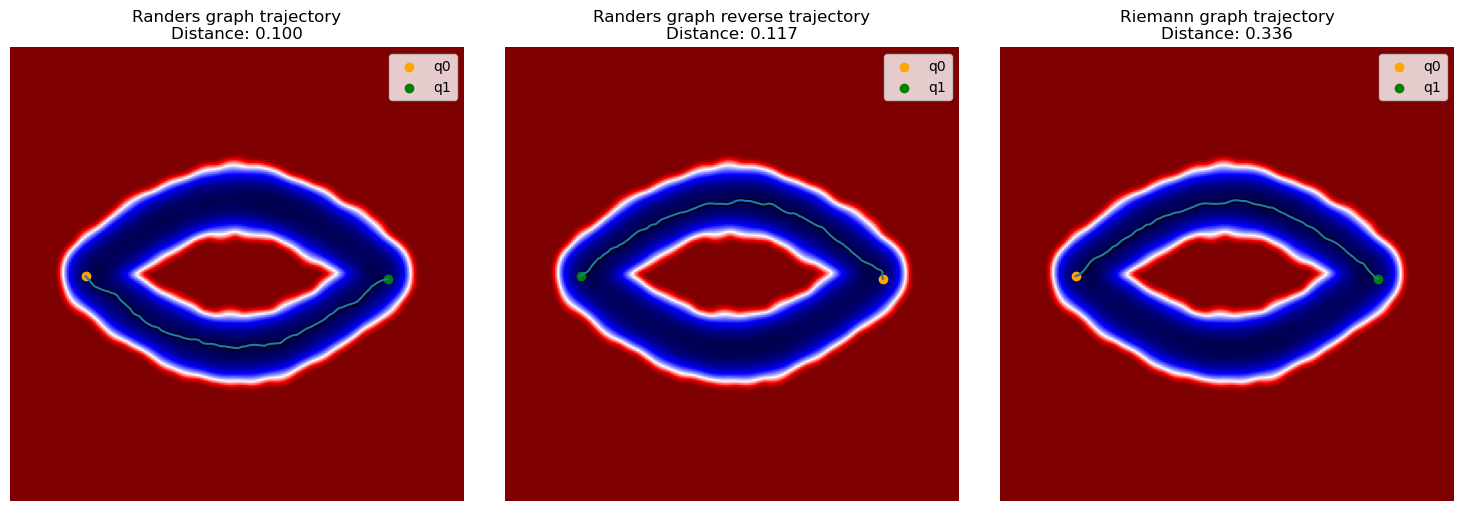

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_traj(
    x_t=traj_0_graph.cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[0],
    cbar=False,
)
plot_traj(
    x_t=traj_1_graph.cpu(),
    q0=q1.cpu(),
    q1=q0.cpu(),
    img=mf,
    extent=extent,
    ax=axes[1],
    cbar=False,
)
plot_traj(
    x_t=traj_riemann_0.cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[2],
    cbar=False,
)
axes[0].set_title(f"Randers graph trajectory\nDistance: {dst_0_graph.item():.3f}")
axes[1].set_title(f"Randers graph reverse trajectory\nDistance: {dst_1_graph.item():.3f}")
axes[2].set_title(f"Riemann graph trajectory\nDistance: {dst_riemann_0.item():.3f}")
for ax in axes:
    ax.set_aspect("equal")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# GEORCE trajectories
traj_0_georce_rf = randers_georce.get_trajectories(q0, q1)
traj_1_georce_rf = randers_georce.get_trajectories(q1, q0)
traj_0_georce_r = riemann_georce.get_trajectories(q0, q1)

dst_0_rf = randers_georce.dst_func(x_0=q0[0], x_t=traj_0_georce_rf[0, 1:-1], x_T=q1[0])
dst_1_rf = randers_georce.dst_func(x_0=q1[0], x_t=traj_1_georce_rf[0, 1:-1], x_T=q0[0])
dst_0_r = riemann_georce.dst_func(x_0=q0[0], x_t=traj_0_georce_r[0, 1:-1], x_T=q1[0])

Iterations:   0%|          | 0/300 [00:00<?, ?it/s]

i=006 | alpha: 2.500E-01, E = 1.910E-04, grad_E = 7.249E-06,  dst = 1.052E-01:   2%|▏         | 6/300 [00:03<02:57,  1.65it/s]
i=017 | alpha: 6.250E-02, E = 1.734E-04, grad_E = 8.436E-06,  dst = 1.096E-01:   6%|▌         | 17/300 [00:09<02:38,  1.79it/s]
i=004 | alpha: 1.562E-02, E = 1.275E-03, grad_E = 4.933E-06,  dst = 3.414E-01:   1%|▏         | 4/300 [00:00<00:11, 25.49it/s]


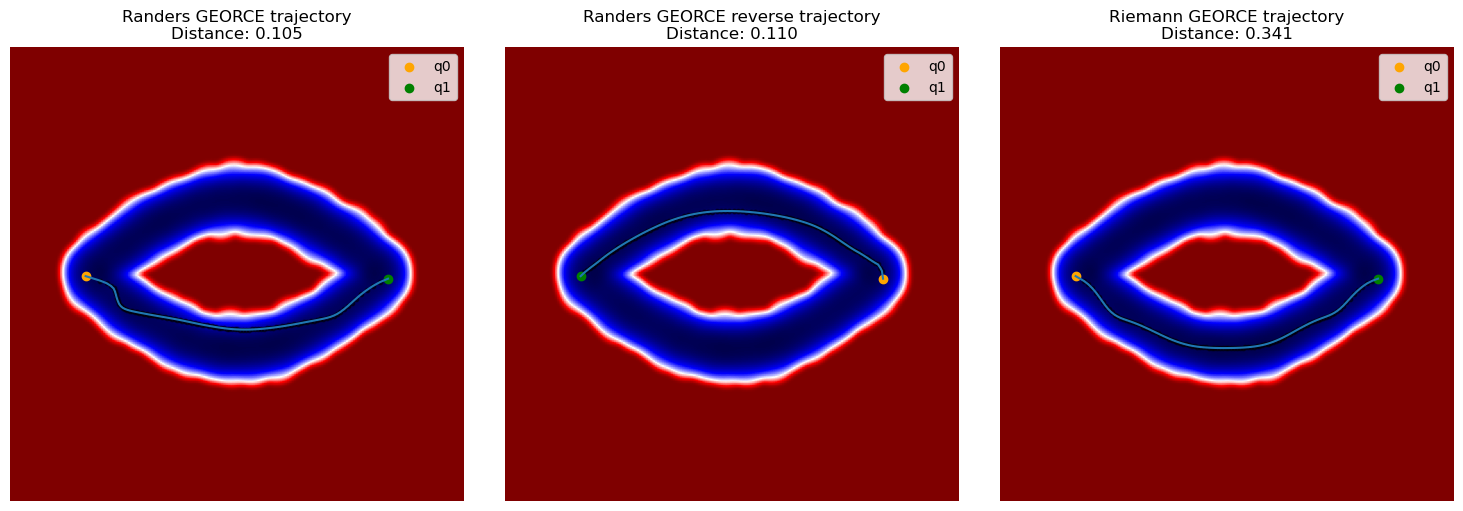

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_traj(
    x_t=traj_0_georce_rf[:, 1:-1].cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[0],
    cbar=False,
)
plot_traj(
    x_t=traj_1_georce_rf[:, 1:-1].cpu(),
    q0=q1.cpu(),
    q1=q0.cpu(),
    img=mf,
    extent=extent,
    ax=axes[1],
    cbar=False,
)
plot_traj(
    x_t=traj_0_georce_r[:, 1:-1].cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[2],
    cbar=False,
)
axes[0].set_title(f"Randers GEORCE trajectory\nDistance: {dst_0_rf.item():.3f}")
axes[1].set_title(f"Randers GEORCE reverse trajectory\nDistance: {dst_1_rf.item():.3f}")
axes[2].set_title(f"Riemann GEORCE trajectory\nDistance: {dst_0_r.item():.3f}")

for ax in axes:
    ax.set_aspect("equal")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Graph-GEORCE trajectories
traj_0_dual_rf = dual_randers_georce.get_trajectories(q0, q1)
traj_1_dual_rf = dual_randers_georce.get_trajectories(q1, q0)
traj_0_dual_r = dual_riemann_georce.get_trajectories(q0, q1)

dst_0_dual_rf = dual_randers_georce.dst_func(x_0=q0[0], x_t=traj_0_dual_rf[0, 1:-1], x_T=q1[0])
dst_1_dual_rf = dual_randers_georce.dst_func(x_0=q1[0], x_t=traj_1_dual_rf[0, 1:-1], x_T=q0[0])
dst_0_dual_r = dual_riemann_georce.compute_distance(traj_0_dual_r)

i=001 | alpha: 7.889E-31, E = 1.791E+00, grad_E = 1.725E-02,  dst = 1.037E+01:   1%|          | 1/100 [00:04<06:58,  4.23s/it]

i=007 | alpha: 2.500E-01, E = 1.910E-04, grad_E = 7.240E-06,  dst = 1.051E-01:   7%|▋         | 7/100 [00:07<01:43,  1.11s/it]
i=001 | alpha: 7.889E-31, E = 6.588E+01, grad_E = 3.806E-01,  dst = 6.289E+01:   1%|          | 1/100 [00:03<06:09,  3.73s/it]

i=017 | alpha: 2.500E-01, E = 1.616E-04, grad_E = 6.947E-06,  dst = 1.184E-01:  17%|█▋        | 17/100 [00:12<00:59,  1.40it/s]
i=005 | alpha: 1.562E-02, E = 1.275E-03, grad_E = 4.933E-06,  dst = 3.414E-01:   5%|▌         | 5/100 [00:00<00:05, 15.86it/s]

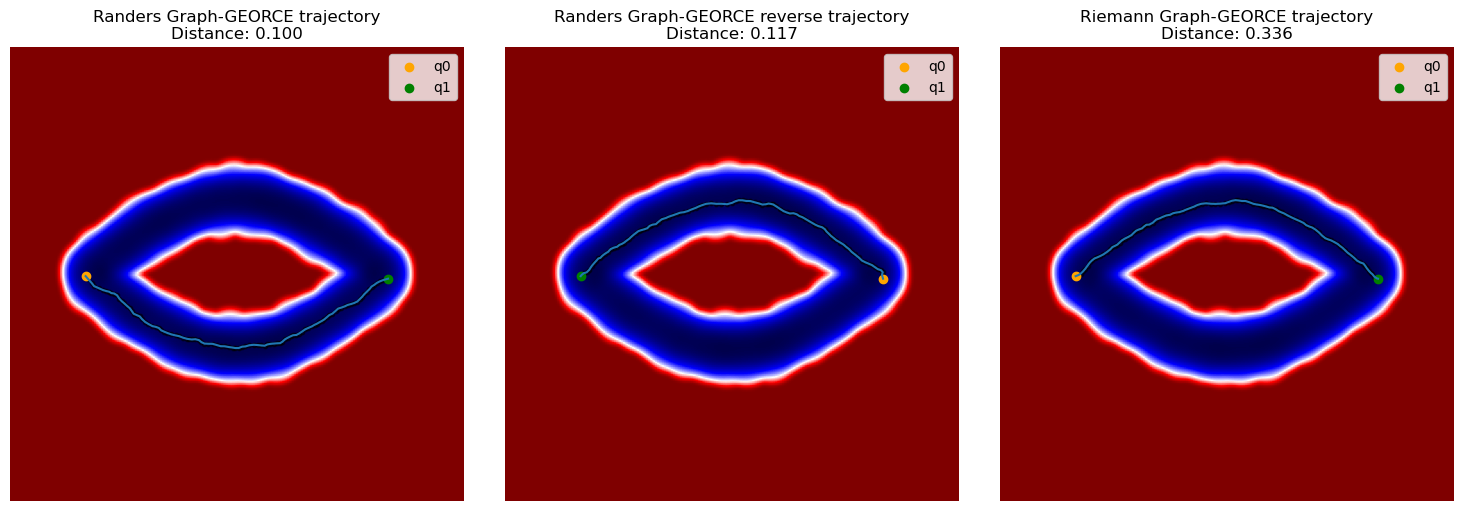

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_traj(
    x_t=traj_0_dual_rf[:, 1:-1].cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[0],
    cbar=False,
)
plot_traj(
    x_t=traj_1_dual_rf[:, 1:-1].cpu(),
    q0=q1.cpu(),
    q1=q0.cpu(),
    img=mf,
    extent=extent,
    ax=axes[1],
    cbar=False,
)
plot_traj(
    x_t=traj_0_dual_r[:, 1:-1].cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[2],
    cbar=False,
)
axes[0].set_title(f"Randers Graph-GEORCE trajectory\nDistance: {dst_0_dual_rf.item():.3f}")
axes[1].set_title(
    f"Randers Graph-GEORCE reverse trajectory\nDistance: {dst_1_dual_rf.item():.3f}"
)
axes[2].set_title(f"Riemann Graph-GEORCE trajectory\nDistance: {dst_0_dual_r.item():.3f}")

for ax in axes:
    ax.set_aspect("equal")
    ax.axis("off")
plt.tight_layout()
plt.show()

### Summary

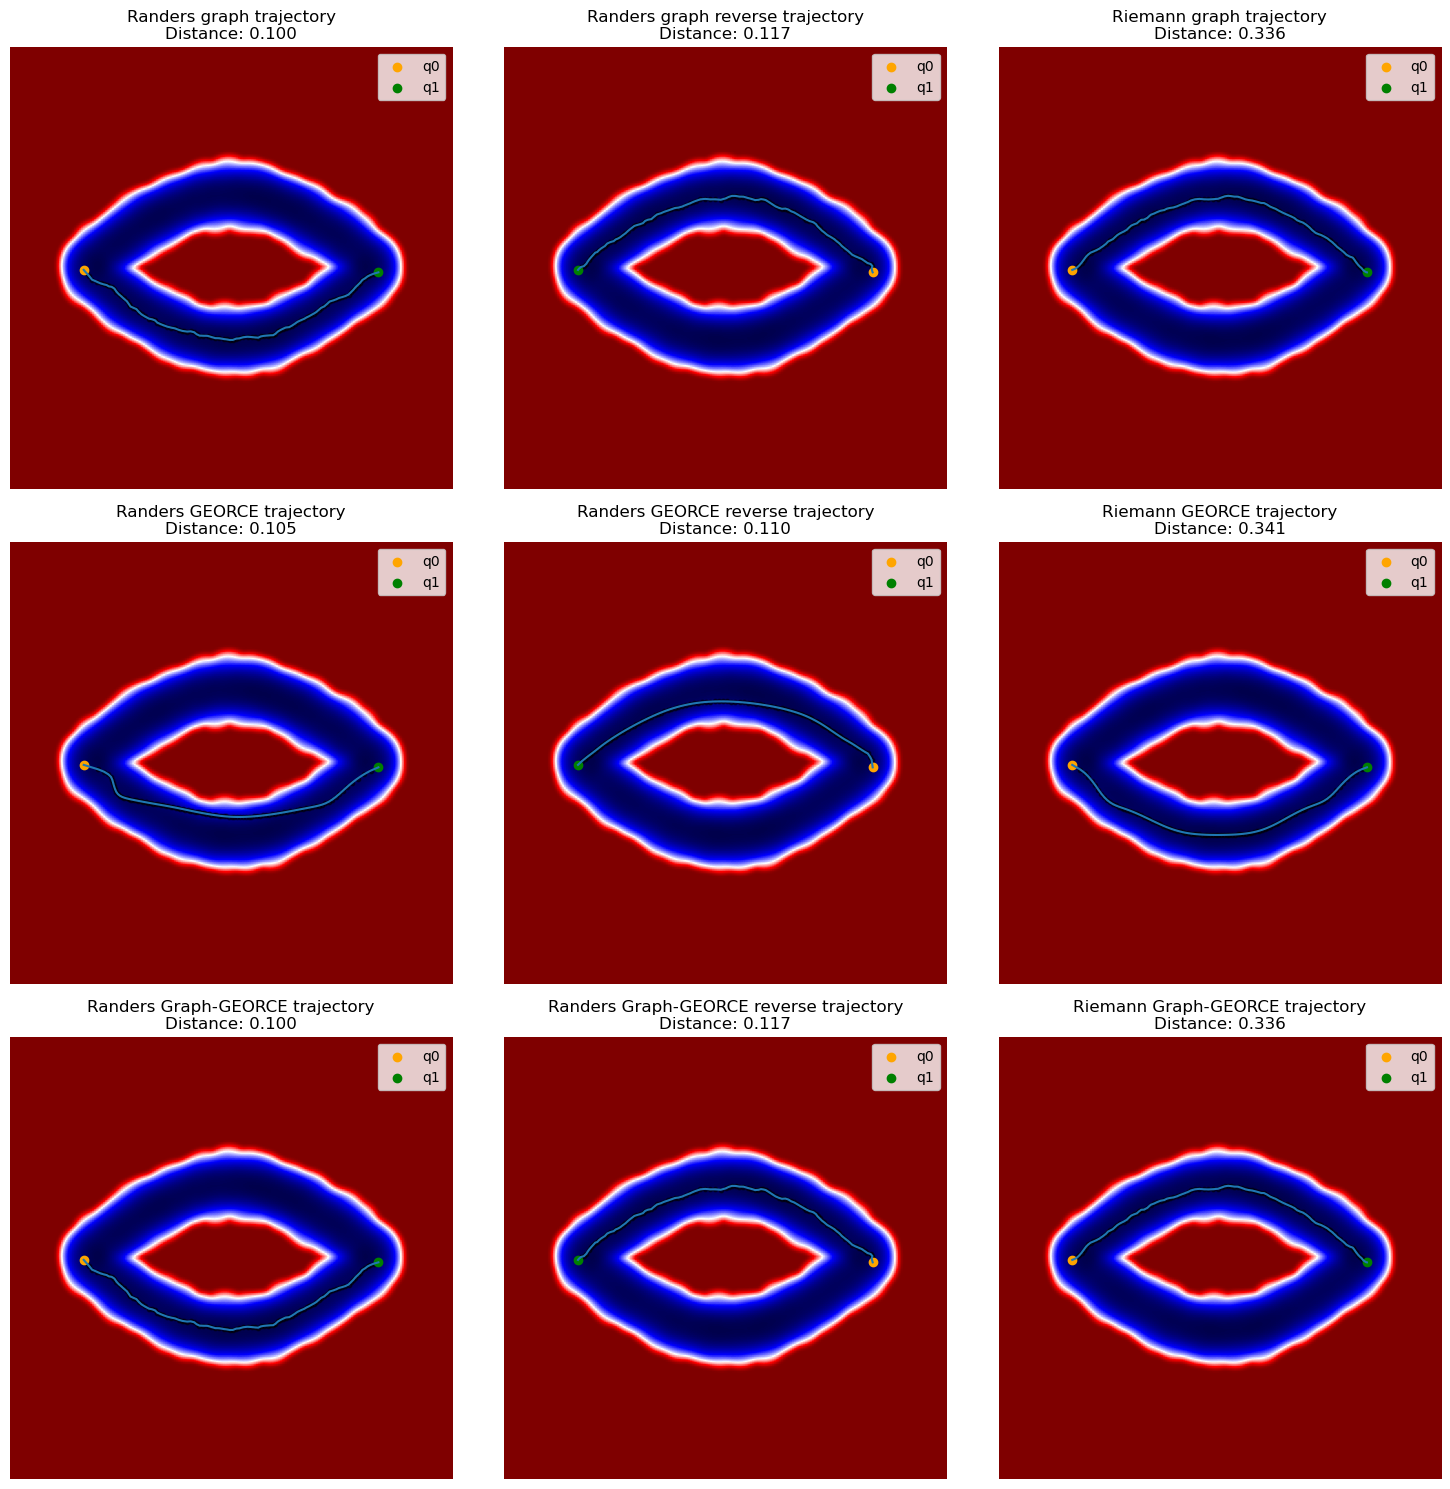

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
plot_traj(
    x_t=traj_0_graph.cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[0],
    cbar=False,
)
plot_traj(
    x_t=traj_1_graph.cpu(),
    q0=q1.cpu(),
    q1=q0.cpu(),
    img=mf,
    extent=extent,
    ax=axes[1],
    cbar=False,
)
plot_traj(
    x_t=traj_riemann_0.cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[2],
    cbar=False,
)
axes[0].set_title(f"Randers graph trajectory\nDistance: {dst_0_graph.item():.3f}")
axes[1].set_title(f"Randers graph reverse trajectory\nDistance: {dst_1_graph.item():.3f}")
axes[2].set_title(f"Riemann graph trajectory\nDistance: {dst_riemann_0.item():.3f}")

plot_traj(
    x_t=traj_0_georce_rf[:, 1:-1].cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[3],
    cbar=False,
)
plot_traj(
    x_t=traj_1_georce_rf[:, 1:-1].cpu(),
    q0=q1.cpu(),
    q1=q0.cpu(),
    img=mf,
    extent=extent,
    ax=axes[4],
    cbar=False,
)
plot_traj(
    x_t=traj_0_georce_r[:, 1:-1].cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[5],
    cbar=False,
)
axes[3].set_title(f"Randers GEORCE trajectory\nDistance: {dst_0_rf.item():.3f}")
axes[4].set_title(f"Randers GEORCE reverse trajectory\nDistance: {dst_1_rf.item():.3f}")
axes[5].set_title(f"Riemann GEORCE trajectory\nDistance: {dst_0_r.item():.3f}")


plot_traj(
    x_t=traj_0_dual_rf[:, 1:-1].cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[6],
    cbar=False,
)
plot_traj(
    x_t=traj_1_dual_rf[:, 1:-1].cpu(),
    q0=q1.cpu(),
    q1=q0.cpu(),
    img=mf,
    extent=extent,
    ax=axes[7],
    cbar=False,
)
plot_traj(
    x_t=traj_0_dual_r[:, 1:-1].cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    img=mf,
    extent=extent,
    ax=axes[8],
    cbar=False,
)
axes[6].set_title(f"Randers Graph-GEORCE trajectory\nDistance: {dst_0_dual_rf.item():.3f}")
axes[7].set_title(
    f"Randers Graph-GEORCE reverse trajectory\nDistance: {dst_1_dual_rf.item():.3f}"
)
axes[8].set_title(f"Riemann Graph-GEORCE trajectory\nDistance: {dst_0_dual_r.item():.3f}")


for ax in axes:
    ax.set_aspect("equal")
    ax.axis("off")
plt.tight_layout()
plt.show()

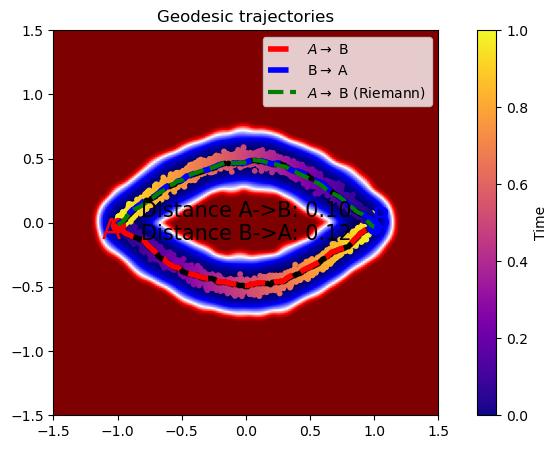

In [ ]:
plt.figure(figsize=(10, 5))
s = plt.scatter(X_all[:, 0].cpu(), X_all[:, 1].cpu(), c=t_all.cpu(), cmap="plasma", s=10)
plt.plot(
    traj_0_graph[0, :, 0].cpu(),
    traj_0_graph[0, :, 1].cpu(),
    c="red",
    linestyle="--",
    label=r"$A\rightarrow$ B",
    linewidth=4,
)
plt.plot(
    traj_1_graph[0, :, 0].cpu(),
    traj_1_graph[0, :, 1].cpu(),
    c="blue",
    linestyle="--",
    label=r"B$\rightarrow$ A",
    linewidth=4,
)
plt.plot(
    traj_riemann_0[0, :, 0].cpu(),
    traj_riemann_0[0, :, 1].cpu(),
    c="green",
    linestyle="--",
    label=r"$A\rightarrow$ B (Riemann)",
    linewidth=3,
)
plt.scatter(traj_0_graph.cpu()[0, :, 0], traj_0_graph.cpu()[0, :, 1], c="black", s=10)
plt.scatter(traj_1_graph.cpu()[0, :, 0], traj_1_graph.cpu()[0, :, 1], c="black", s=10)
plt.scatter(q0.cpu()[:, 0], q0.cpu()[:, 1], c="red", s=100)
plt.text(
    q0.cpu()[:, 0] - 0.05,
    q0.cpu()[:, 1] - 0.05,
    "A",
    fontsize=20,
    color="red",
    ha="center",
    va="center",
)
plt.scatter(q1.cpu()[:, 0], q1.cpu()[:, 1], c="blue", s=100)
plt.text(
    q1.cpu()[:, 0] + 0.05,
    q1.cpu()[:, 1] + 0.05,
    "B",
    fontsize=20,
    color="blue",
    ha="center",
    va="center",
)
plt.text(
    0.0,
    0.0,
    f"Distance A->B: {dst_0_graph.item():.2f}\nDistance B->A: {dst_1_graph.item():.2f}",
    fontsize=15,
    ha="center",
    va="center",
)
plt.imshow(mf.log(), cmap="seismic", extent=extent, origin="lower", alpha=1)
# plt.axis("equal")
plt.colorbar(s, label="Time")
plt.title("Geodesic trajectories")
# plt.xlabel(r''
plt.legend()
plt.show()

## Examine solver

In [ ]:
# Make some room
del traj_0_graph, traj_1_graph, traj_riemann_0
del traj_0_georce_rf, traj_1_georce_rf, traj_0_georce_r
del traj_0_dual_rf, traj_1_dual_rf, traj_0_dual_r

del dst_0_graph, dst_1_graph, dst_riemann_0
del dst_0_rf, dst_1_rf, dst_0_r
del dst_0_dual_rf, dst_1_dual_rf, dst_0_dual_r

torch.cuda.empty_cache()

In [ ]:
x_final, dst_list, norm_gE_list, E_list, alpha_list = randers_georce.georce_solver(
    q0.squeeze(0), q1.squeeze(0)
)
x_final_1, dst_list_1, norm_gE_list_1, E_list_1, alpha_list_1 = randers_georce.georce_solver(
    q1.squeeze(0), q0.squeeze(0)
)

i=006 | alpha: 2.500E-01, E = 1.910E-04, grad_E = 7.249E-06,  dst = 1.052E-01:   2%|▏         | 6/300 [00:03<02:46,  1.76it/s]
i=017 | alpha: 6.250E-02, E = 1.734E-04, grad_E = 8.436E-06,  dst = 1.096E-01:   6%|▌         | 17/300 [00:09<02:40,  1.76it/s]


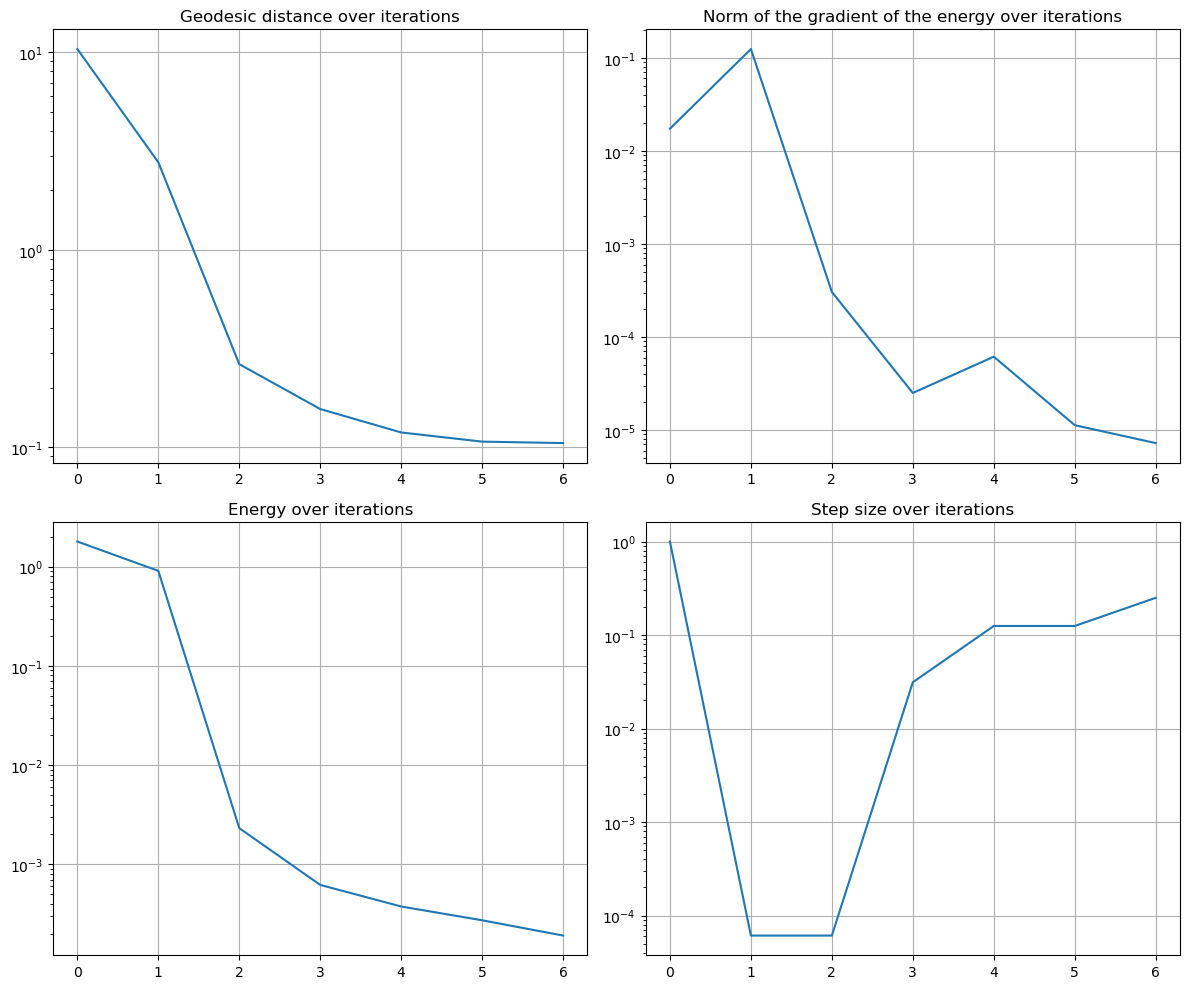

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
axes[0].plot(dst_list)
axes[0].set_title("Geodesic distance over iterations")
axes[1].plot(norm_gE_list)
axes[1].set_title("Norm of the gradient of the energy over iterations")
axes[2].plot(E_list)
axes[2].set_title("Energy over iterations")
axes[3].plot(alpha_list)
axes[3].set_title("Step size over iterations")
for ax in axes:
    ax.set_yscale("log")
    ax.grid(True)
plt.tight_layout()
plt.show()

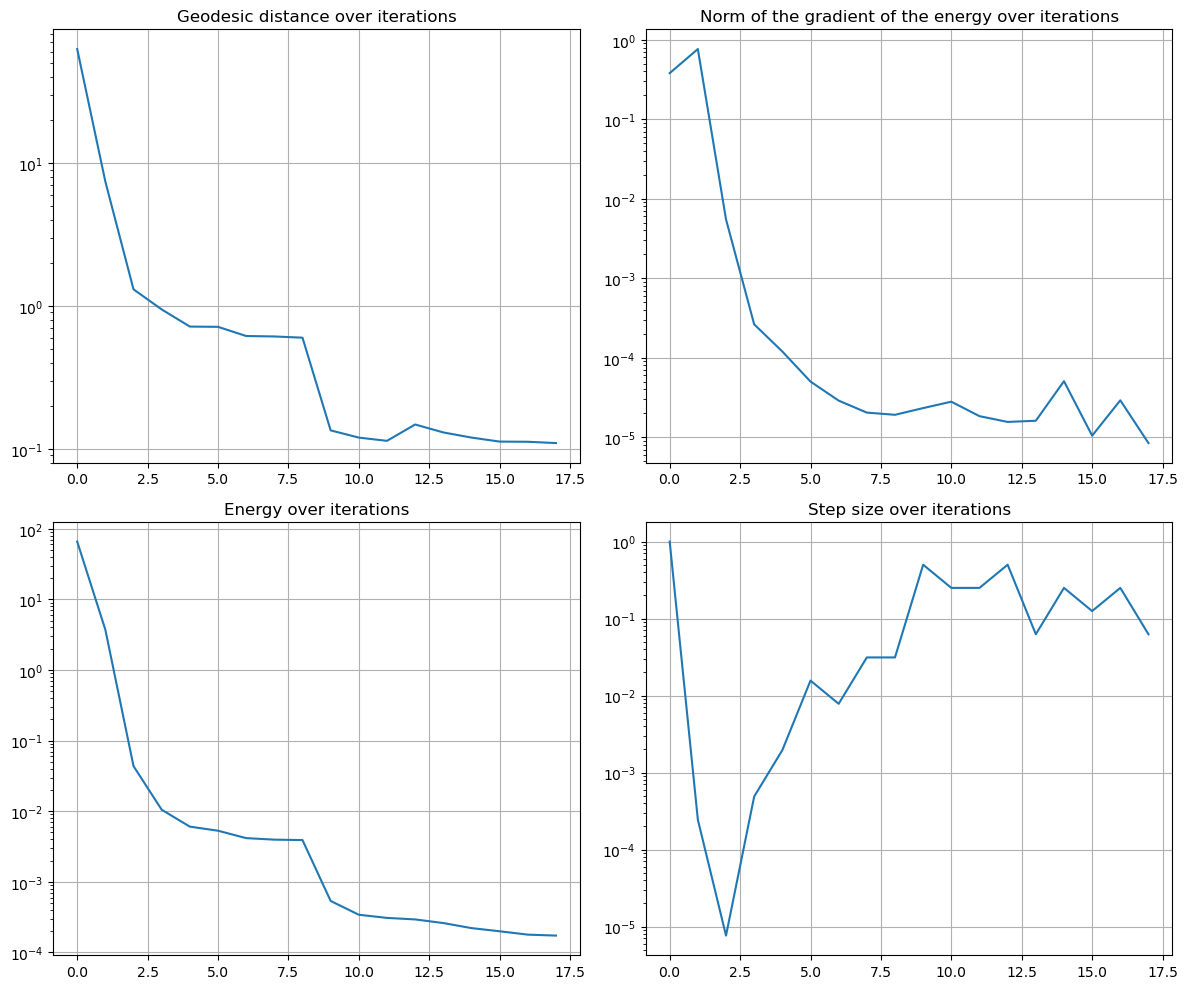

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
axes[0].plot(dst_list_1)
axes[0].set_title("Geodesic distance over iterations")
axes[1].plot(norm_gE_list_1)
axes[1].set_title("Norm of the gradient of the energy over iterations")
axes[2].plot(E_list_1)
axes[2].set_title("Energy over iterations")
axes[3].plot(alpha_list_1)
axes[3].set_title("Step size over iterations")
for ax in axes:
    ax.set_yscale("log")
    ax.grid(True)
plt.tight_layout()
plt.show()